In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from torch.utils.data import DataLoader, Subset
from IPython.display import HTML
from scipy import linalg
import pandas as pd
import os
import time

torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

LR = 5e-5
BATCH_SIZE = 128
IMG_SIZE = 64
IMG_CHANNELS = 3
LATENT_DIM = 100
EPOCHS = 40
DISC_FEATURES = 64
GEN_FEATURES = 64
beta = 0.5

if not os.path.exists('Results'):
    os.makedirs('Results')
if not os.path.exists('Models'):
    os.makedirs('Models')

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

Device: cpu


Files already downloaded and verified


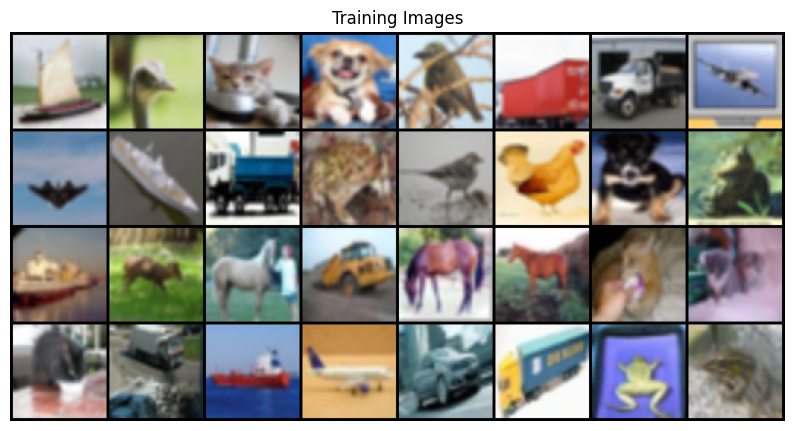

In [2]:
cifar10_dataset = datasets.CIFAR10(root="./dataset/CIFAR10data", download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(cifar10_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

real_batch = next(iter(data_loader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [3]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, disc_features):
        super(Discriminator, self).__init__()
        self.disc_net = nn.Sequential(
            nn.Conv2d(img_channels, disc_features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self.disc_block(disc_features, disc_features * 2, 4, 2, 1),
            self.disc_block(disc_features * 2, disc_features * 4, 4, 2, 1),
            self.disc_block(disc_features * 4, disc_features * 8, 4, 2, 1),
            nn.Conv2d(disc_features * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def disc_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc_net(x)

class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels, gen_features):
        super(Generator, self).__init__()
        self.gen_net = nn.Sequential(
            self.gen_block(latent_dim, gen_features * 16, 4, 1, 0),
            self.gen_block(gen_features * 16, gen_features * 8, 4, 2, 1),
            self.gen_block(gen_features * 8, gen_features * 4, 4, 2, 1),
            self.gen_block(gen_features * 4, gen_features * 2, 4, 2, 1),
            nn.ConvTranspose2d(gen_features * 2, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def gen_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.gen_net(x)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [4]:
generator = Generator(LATENT_DIM, IMG_CHANNELS, GEN_FEATURES).to(device)
discriminator = Discriminator(IMG_CHANNELS, DISC_FEATURES).to(device)
initialize_weights(generator)
initialize_weights(discriminator)

optimizer_G = optim.Adam(generator.parameters(), lr=LR, betas=(beta, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR, betas=(beta, 0.999))

criterion = nn.BCELoss()
fixed_noise = torch.randn(32, LATENT_DIM, 1, 1).to(device)

generator.train()
discriminator.train()

Discriminator(
  (disc_net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [5]:
class InceptionV3(nn.Module):
    DEFAULT_BLOCK_INDEX = 3
    BLOCK_INDEX_BY_DIM = {
        64: 0,
        192: 1,
        768: 2,
        2048: 3
    }

    def __init__(self, output_blocks=[DEFAULT_BLOCK_INDEX], resize_input=True, normalize_input=True, requires_grad=False):
        super(InceptionV3, self).__init__()
        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)
        assert self.last_needed_block <= 3, 'Last possible output block index is 3'
        self.blocks = nn.ModuleList()
        inception = models.inception_v3(pretrained=True)
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))
        for param in self.parameters():
            param.requires_grad = requires_grad

In [6]:
def forward(self, inp):
        outp = []
        x = inp
        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        if self.normalize_input:
            x = 2 * x - 1
        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)
            if idx == self.last_needed_block:
                break
        return outp

In [7]:
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception_model = InceptionV3([block_idx])
inception_model = inception_model.cuda()

/Library/Python/3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Python/3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AssertionError: Torch not compiled with CUDA enabled

In [8]:
def calculate_activation_statistics(images, model, dims=2048, cuda=False):
    model.eval()
    act = np.empty((len(images), dims))
    if cuda:
        batch = images.cuda()
    else:
        batch = images
    pred = model(batch)[0]
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = F.adaptive_avg_pool2d(pred, output_size=(1, 1))
    act = pred.cpu().data.numpy().reshape(pred.size(0), -1)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)
    assert mu1.shape == mu2.shape, 'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, 'Training and test covariances have different dimensions'
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real
    tr_covmean = np.trace(covmean)
    return (diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean)

def calculate_fid(real_images, fake_images, model):
    mu_real, sigma_real = calculate_activation_statistics(real_images, model, cuda=True)
    mu_fake, sigma_fake = calculate_activation_statistics(fake_images, model, cuda=True)
    fid_value = calculate_frechet_distance(mu_real, sigma_real, mu_fake, sigma_fake)
    return fid_value

In [ ]:
gen_losses = []
disc_losses = []
generated_images = []
fid_scores = []
iters = 0
print("Training")
start_time = time.time()

for epoch in range(EPOCHS):
    for batch_idx, data in enumerate(data_loader, 0):
        real_images = data[0].to(device)
        noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1).to(device)
        fake_images = generator(noise)

        # Train Discriminator
        disc_real = discriminator(real_images).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = discriminator(fake_images.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        disc_loss = (loss_disc_real + loss_disc_fake) / 2
        discriminator.zero_grad()
        disc_loss.backward()
        optimizer_D.step()

        # Train Generator
        output = discriminator(fake_images).reshape(-1)
        gen_loss = criterion(output, torch.ones_like(output))
        generator.zero_grad()
        gen_loss.backward()
        optimizer_G.step()

        gen_losses.append(gen_loss.detach().cpu())
        disc_losses.append(disc_loss.detach().cpu())

        if (iters % 500 == 0) or ((epoch == EPOCHS - 1) and (batch_idx == len(data_loader) - 1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
                generated_images.append(utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        # Calculate FID
        fid = calculate_fid(real_images, fake_images, inception_model)
        fid_scores.append(fid)

        if epoch % 5 == 0:
            print(f'\nEpoch [{epoch + 1}/{EPOCHS}] Batch {batch_idx}/{len(data_loader)} '
                  f'Discriminator Loss: {disc_loss:.3f}, Generator Loss: {gen_loss:.3f}, FID: {fid:.3f}')

    # Save generated images
    generated = generator(fixed_noise)
    if not os.path.exists('Results/DCGAN_FAKE'):
        os.makedirs('Results/DCGAN_FAKE')
    if not os.path.exists('Results/DCGAN_REAL'):
        os.makedirs('Results/DCGAN_REAL')
    utils.save_image(generated.detach(), f'Results/DCGAN_FAKE/DCGAN50_epoch_{epoch + 1:03d}.png', normalize=True)
    utils.save_image(real_images.detach(), f'Results/DCGAN_REAL/DCGAN50_epoch_{epoch + 1:03d}.png', normalize=True)

end_time = time.time()
print(f'\n\nElapsed time: {end_time - start_time:.2f} seconds.')

print("Generator Loss - Mean: {:.3f}, Min: {:.3f}, Last: {:.3f}".format(
    np.mean(gen_losses), np.min(gen_losses), gen_losses[-1]))
print("Discriminator Loss - Mean: {:.3f}, Min: {:.3f}, Last: {:.3f}".format(
    np.mean(disc_losses), np.min(disc_losses), disc_losses[-1]))

if not os.path.exists('Results/Loss_Data'):
    os.makedirs('Results/Loss_Data')
np.save('Results/Loss_Data/DCGAN_GLoss', gen_losses)
np.save('Results/Loss_Data/DCGAN_DLoss', disc_losses)

gen_losses = np.load('Results/Loss_Data/DCGAN_GLoss.npy')
disc_losses = np.load('Results/Loss_Data/DCGAN_DLoss.npy')

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses, label="Generator")
plt.plot(disc_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Results/loss.pdf', format='pdf', bbox_inches='tight')
plt.show()

real_batch = next(iter(data_loader))
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:32], padding=5, normalize=True).cpu(), (1, 2, 0)))
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(generated_images[-1], (1, 2, 0)))
plt.savefig('Results/DCGAN_Best_Fake_32.pdf', format='pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 5))
plt.title("FID Scores for DCGAN")
plt.plot(fid_scores, label="DCGAN")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.savefig('Results/FID.pdf', format='pdf', bbox_inches='tight')
plt.show()

if not os.path.exists('Results/FID_score'):
    os.makedirs('Results/FID_score')
np.save('Results/FID_score/DCGAN_FID', fid_scores)

print("FID Scores - Min: {:.3f}, Max: {:.3f}, Mean: {:.3f}, Last: {:.3f}".format(
    np.min(fid_scores), np.max(fid_scores), np.mean(fid_scores), fid_scores[-1]))

